In [23]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from numba import jit


df = load_df()
df = df.fillna(0)

version = "target"
target = "fix_two_sided_ptu"
train_set = "train"
test_set = "valid"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Number of used features: 40
Using CPU


/tmp/ipykernel_13163/403115624.py:89: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  splits[test_set][0].fillna(0).values.astype(np.float32),


Epoch 1/100, Train Loss: 71.67984108906384, Validation Loss: 93.99337786970467, Validation Accuracy: 0.9066091954022989
Epoch 2/100, Train Loss: 95.10976920411261, Validation Loss: 93.99337786970467, Validation Accuracy: 0.9066091954022989
Epoch 3/100, Train Loss: 95.10976912821295, Validation Loss: 93.99337786970467, Validation Accuracy: 0.9066091954022989
Epoch 4/100, Train Loss: 95.10976920164833, Validation Loss: 93.99337786970467, Validation Accuracy: 0.9066091954022989
Early stopping after epoch 4 with no improvement.


/tmp/ipykernel_13163/403115624.py:195: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_pred = model(torch.tensor(splits[test_set][0].fillna(0).values.astype(np.float32), dtype=torch.float32).to(device))
/home/nub/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nub/miniconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

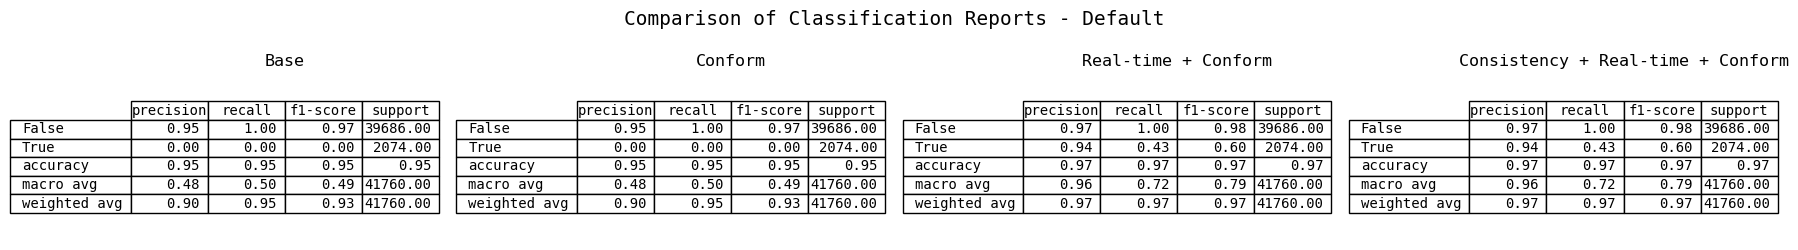

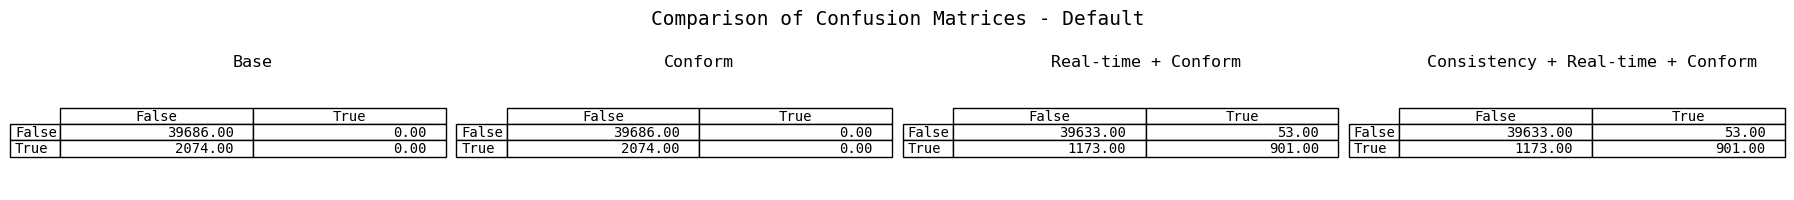

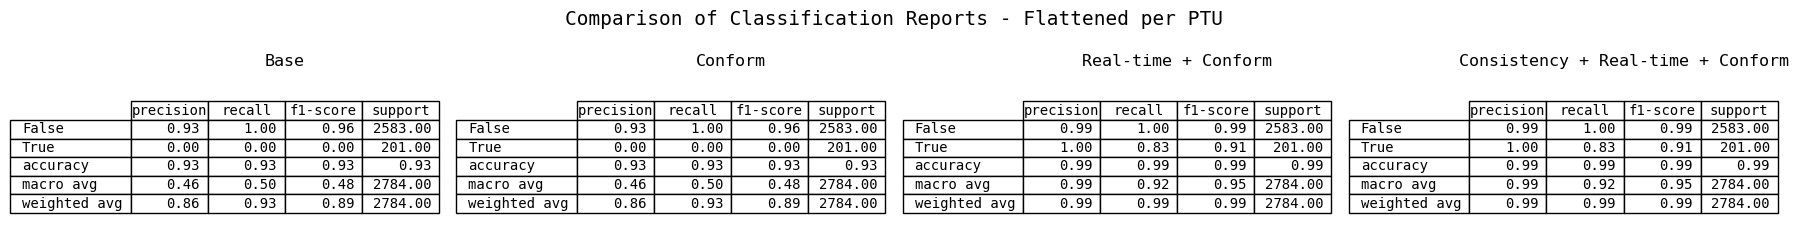

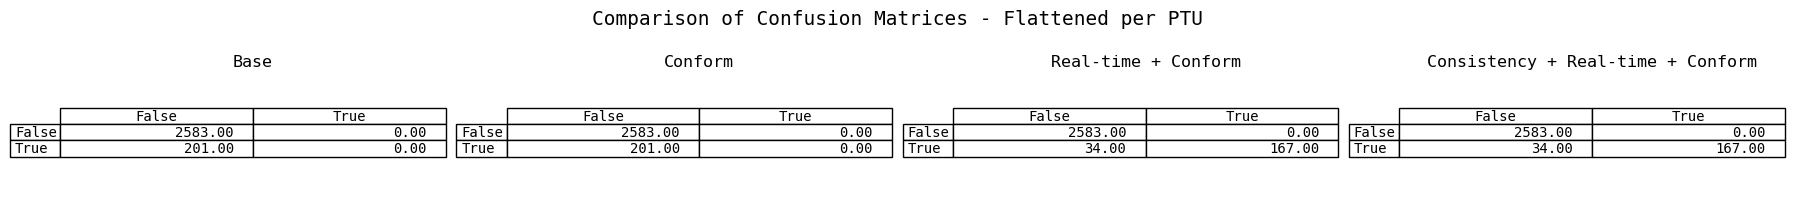

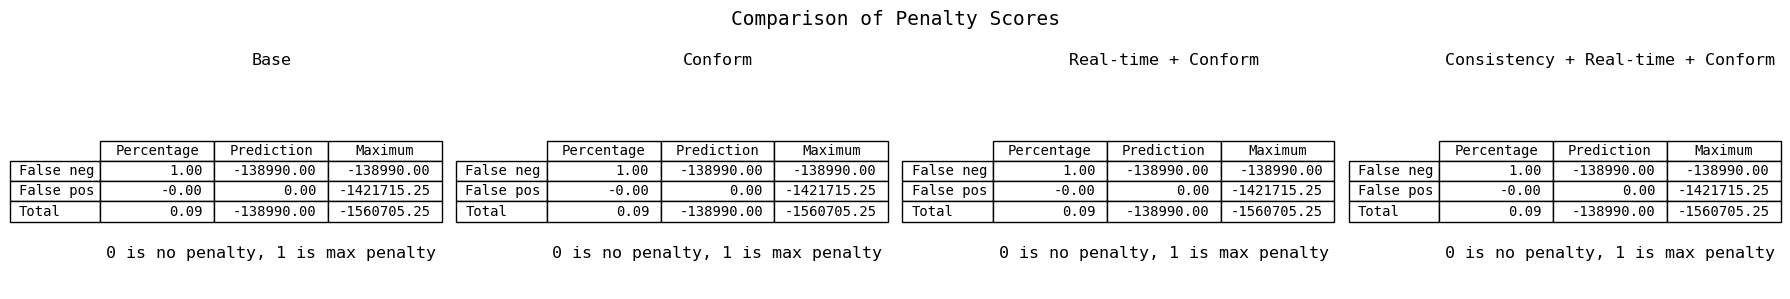

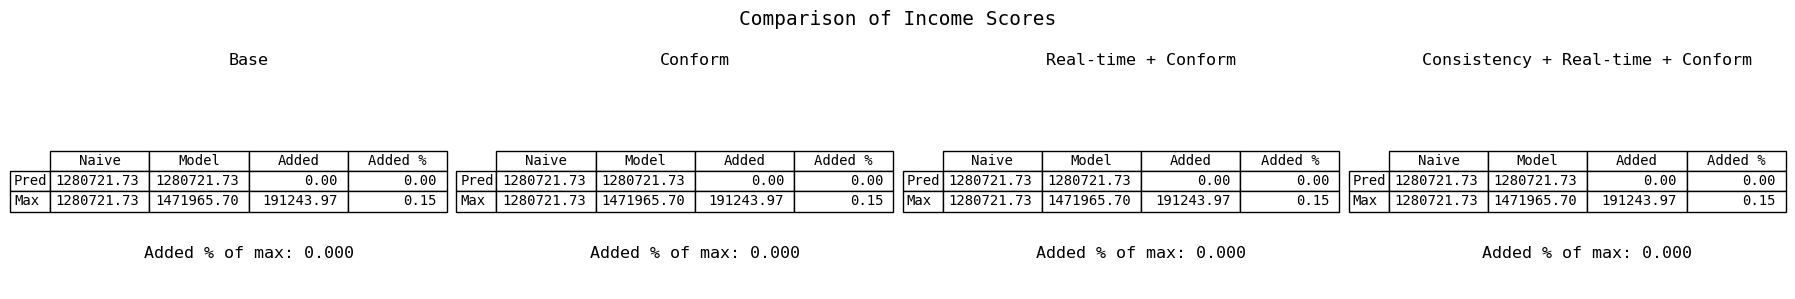

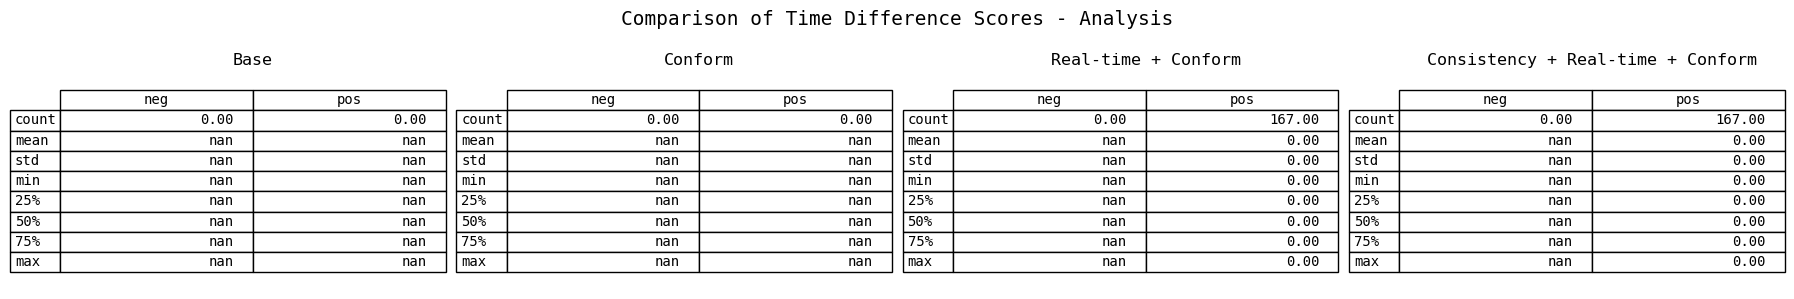

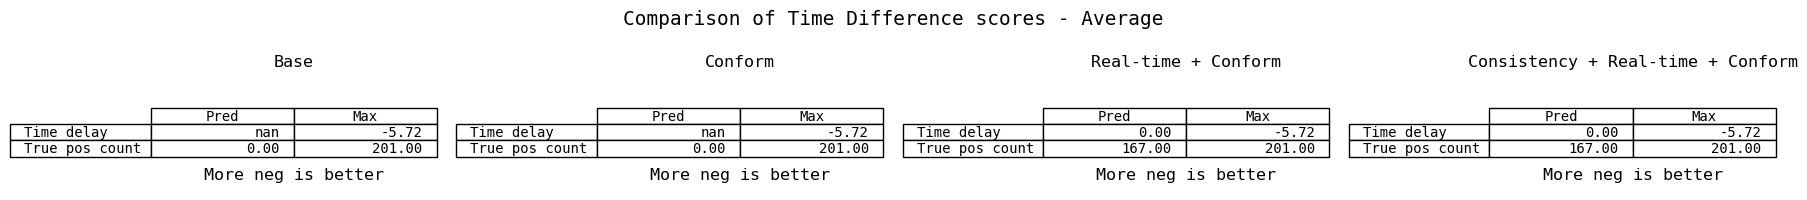

In [26]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    "fix_min_ptu_price_known",  # combine all
    "fix_max_ptu_price_known",  # combine all
    "fix_settlement_price_bestguess_alt",  # combine all
    "settlement_price_bestguess_alt",
    # "upward_dispatch_published",
    # "downward_dispatch_published",
    # "igcc_contribution_up_published",
    # "igcc_contribution_down_published",
    "time_since_last_two_sided",
    "time_since_last_two_sided_alt",  # combine all
    "two_sided_daily_count",
    "PTU",
    "minute_in_ptu",
    "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    # "forecast_wind",
    # "forecast_solar",
    # "forecast_demand",
    # "forecast_wind_delta",
    # "forecast_solar_delta",
    # "forecast_demand_delta",
    "fix_two_sided_ptu_realtime",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    "is_balanced",
    "weekday",
    "workday",
    # "hour",
    "month",
    # "day",
    # "minute",
    # "down_negative",
    "down_price_volume",
    "up_price_volume",
    # "diff_price_volume",
    # "started_down",
    # "max_price_filled_known",
    "last_15min_up_volume",
    "last_15min_down_volume",
    "downward_dispatch_published_peak",
    "downward_dispatch_published_peak_time",
    "downward_dispatch_published_peak_diff",
    # "upward_dispatch_published_peak",
    # "upward_dispatch_published_peak_time",
    # "upward_dispatch_published_peak_diff",
    "igcc_contribution_down_published_peak",
    "igcc_contribution_down_published_peak_time",
    "igcc_contribution_down_published_peak_diff",
    # "igcc_contribution_up_published_peak",
    # "igcc_contribution_up_published_peak_time",
    # "igcc_contribution_up_published_peak_diff",
    # "reconstruction",
    # "last_15min_recon",
    # "recon_diff",
    # "last_15min_recon_true",
    # "recon_diff_true",
    # "last_15min_recon_false",
    # "recon_diff_false",
    # "recon_diff_base",
    # "recon_diff_total",
    # "price_pred",
    # "eneco_pred",
    "min_price_published_1",
    "max_price_published_1",
    "fix_two_sided_ptu_17",
    "settlement_price_realized_17",
    "minute_in_ptu_2"
]
print("Number of used features:", len(features))
splits = get_splits(df, features, target, return_dict_pair=False)

mask = splits[train_set][3]["started_down"]

t = np.ones(len(mask), dtype=bool)
t[:15 * 2] = False
mask = mask & t

# Check if CUDA (GPU) is available and set the device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Create PyTorch datasets and dataloaders
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, action, price):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).reshape((len(y), 1)).to(device)
        self.action = torch.tensor(action, dtype=torch.bool).reshape((len(action), 1)).to(device)
        self.price = torch.tensor(price, dtype=torch.float32).reshape((len(price), 1)).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.action[idx], self.price[idx]


train_dataset = CustomDataset(
    splits[train_set][0].values.astype(np.float32),
    splits[train_set][1].values.astype(np.float32),
    splits[train_set][3]["naive_strategy_action"].values.astype(np.bool_),
    splits[train_set][3]["settlement_price_realized"].values.astype(np.float32)
)
test_dataset = CustomDataset(
    splits[test_set][0].values.astype(np.float32),
    splits[test_set][1].values.astype(np.float32),
    splits[test_set][3]["naive_strategy_action"].values.astype(np.bool_),
    splits[test_set][3]["settlement_price_realized"].values.astype(np.float32)
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the custom loss function
def custom_loss(y_true, y_pred, action, price):
    pred = 1 - y_pred.round()
    true = 1 - y_true
    naive_val = -price * action
    pred_val = naive_val * pred
    best_val = naive_val * true
    diff_val = pred_val - best_val
    diff = pred - true
    return torch.mean(torch.sqrt(torch.abs(torch.minimum(diff_val * 10, diff_val))) + torch.abs(torch.maximum(diff, diff * 1000)))

# Define the model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout()
        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout()
        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.sigmoid(self.fc4(x))
        return x

model = SimpleNN(input_dim=splits[train_set][0].shape[1]).to(device)
# model.load_state_dict(load_model("test", "custom_loss"))
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.05)
max_epochs = 100

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
early_stopping_counter = 0
best_val_loss = np.inf
best_model = None

# Training loop
for epoch in range(max_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch, action_batch, price_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = custom_loss(y_batch, y_pred, action_batch, price_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Evaluation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for X_batch, y_batch, action_batch, price_batch in val_loader:
            y_pred = model(X_batch)
            loss = custom_loss(y_batch, y_pred, action_batch, price_batch)
            val_loss += loss.item()
            pred = y_pred.round()  # for binary classification
            correct += (pred == y_batch).sum().item()
            total += y_batch.size(0)

        val_loss /= len(val_loader)
        accuracy = correct / total
        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {accuracy}")
    
    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        save_model(best_model, "test", "custom_loss")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Early stopping logic
    if early_stopping_counter >= patience:
        print(f'Early stopping after epoch {epoch+1} with no improvement.')
        break

# Load the best model weights
if best_model:
    model.load_state_dict(best_model)

# Make predictions
with torch.no_grad():
    y_pred = model(torch.tensor(splits[test_set][0]..values.astype(np.float32), dtype=torch.float32).to(device))


show_metrics_adjusted(splits[test_set][3], pd.Series(y_pred[:, 0] > 0.5), version=version)


In [25]:
p_tr, _ = test(best[0], splits["train"][0])
show_metrics_adjusted(splits["train"][3], p_tr, version=version)

p_va, _ = test(best[0], splits["valid"][0])
show_metrics_adjusted(splits["valid"][3], p_va, version=version)

p_te, _ = test(best[0], splits["test"][0])
show_metrics_adjusted(splits["test"][3], p_te, version=version)

NameError: name 'test' is not defined

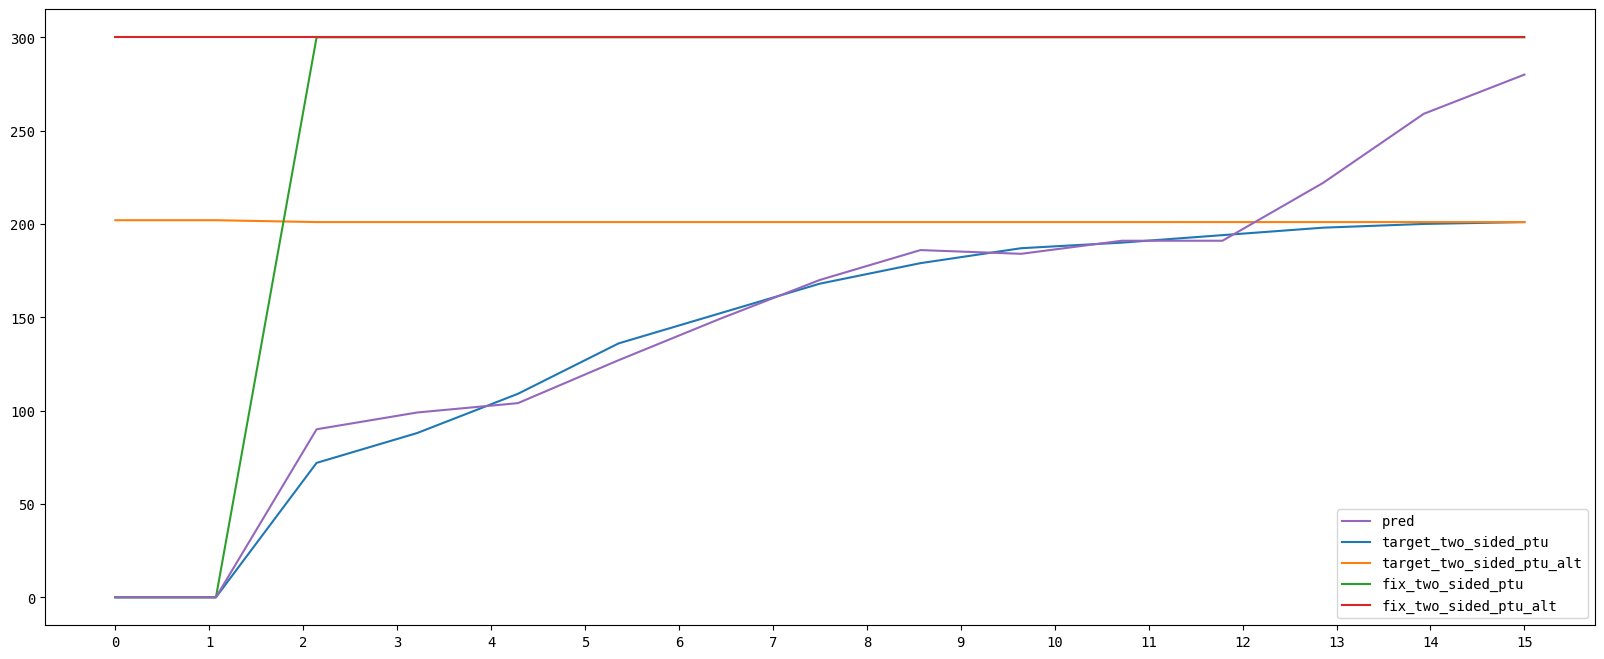

In [ ]:
targets = [
    "target_two_sided_ptu",
    "target_two_sided_ptu_alt",
    # "target_two_sided_ptu_realtime",
    "fix_two_sided_ptu",
    "fix_two_sided_ptu_alt",
    # "fix_two_sided_ptu_realtime",
    "pred"
]
agg_dict = {t: "sum" for t in targets}
view = splits[test_set][3]
view["pred"] = p1
items = 15
flat_df = view.groupby("minute_in_ptu").agg(agg_dict)
flat_df.index = np.linspace(0, items, items)

for t in targets:
    plot_against_index(flat_df[t], show=False)
plt.xticks(range(0, items + 1, 1))
show_graph()